# Modeling single-substrate enzyme kinetics


Before we start we must import reqired python modules. We need Numpy, numeric python module for  high-performance vectorized operations on arrays; Pandas, a library providing easy-to-use data structures and data analysis tools; and Matplotlib, a library for creating high quality plots. The module SciPy (scientific Python) SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, ODE solvers and other tasks common in science. 

In [2]:
import numpy as np  
import pandas # convenience wrap for numpy 
from scipy.integrate import odeint # function for solving ordinary differential equations
from scipy.special import lambertw # implementation of Lambert W function
import matplotlib.pyplot as plt # plotting graphics library
#%matplotlib auto
#plt.ioff() # uncomment if you prefer to output graphs into separate windows rather than showing them inline.
%matplotlib inline 
#uncomment if you like inline figures

#### We will explore 5 models: 
1. Sequential kinetic model;
$$E+S \underset{k_{-1}}
{\overset{k_{1}}{\rightleftharpoons}} ES\overset{k_{2}}{\rightarrow}E+P$$
$$\left [ \frac{\mathrm{d} [S]}{\mathrm{d} t}=k_{-1}[ES]-k_{1}[E][S];\; \frac{\mathrm{d} [E]}{\mathrm{d} t}=k_{-1}[ES]+k_{2}[ES]-k_{1}[E][S];\; \frac{\mathrm{d} [ES]}{\mathrm{d} t}=k_{1}[E][S]]-k_{-1}[ES]-k_{2}[ES];\;\frac{\mathrm{d} [P]}{\mathrm{d} t}=k_{2}[ES] \right ]$$

2. Standard Steady-state approximation (Michaelis-Menten equation);
$$velocity=-\frac{\mathrm{d} [S]}{\mathrm{d} t}=\frac{V_{max}[S]}{K_{M}+[S]
}$$
where [S] – substrate concentration, Vmax – maximal rate, KM  – Michaelis constant; condition: [E]o << [S]o

3. Total Steady-state approximation (Total Michaelis-Menten equation);
$$-\frac{\mathrm{d} [S]}{\mathrm{d} t}=k_{cat}\frac{[E]_{o}+K_{M}+[S]-\sqrt{([E]_{o}+K_{M}+[S])^{2}-4E_{o}[S]}}{2
}$$

4. Analytical solution of Michaelis-Menten equation (via Lambert W function).
$$[S]=K_{M}LambertW\left \{ {\frac{[S]_{o}}{K_{M}}exp\left ( {\frac{[S]_{o}-V_{max}t}{K_{M}}} \right )} \right \}$$
5. First order approximation.
$$velocity=-\frac{\mathrm{d} [S]}{\mathrm{d} t}=\frac{V_{max}[S]}{K_{M}}$$
In all examples, we will monitor substrate concentration [S].



In [3]:
# Differential Models: functions that returns dy/dt
def model_full(init,t,*args): 
    '''Complete Sequential kinetics model'''
    S,E,SE,P=init
    k1,k1r,k2=args
    dSdt=-k1*S*E+k1r*SE
    dEdt=-k1*S*E+k1r*SE+k2*SE
    dSEdt=k1*S*E-k1r*SE-k2*SE
    dPdt=k2*SE
    return (dSdt,dEdt,dSEdt,dPdt)

def modelMM(S,t,*args): 
    '''Standard Quasi Steady-State Approximation(Michaelis-Menten equation)'''
    KM,Vm=args #These are parameters that have to be optimized
    dSdt=-Vm*S/(KM+S) # differential equation
    return (dSdt)# returns rates of concentration change

def modelTMM(S,t,*args): 
    '''Total Quasi Steady-State Approximation'''
    KM,kcat,E=args #These are parameters that have to be optimized
    dSdt=-kcat*(E+KM+S-np.sqrt((E+KM+S)**2-4*E*S))/2 # differential equation
    return (dSdt)# returns rates of concentration change

def modelW(t,KM,Vm,So):
    '''"Analytical Model" - analytical solution of Michaelis-Menten equation
    using Lambert W function
    '''
    S=KM*lambertw(So*np.exp((So-Vm*t)/KM)/KM)
    return np.real(S.values)

def modelEXP(t,So,k): #t is independent variable; A,B,C,k1,k2-parameters to be optimized 
    '''Exponential decay S=So+B*exp(-k1*t)'''
    return So*np.exp(-k*t) # returns current substrate concentration 


### Define initial conditions and constants
Note relationships between constants:

$$K_{M}= {\frac{k_{2}-k_{-1}}{k_{1}}}$$

$$V_{max}= k_{cat}[E]_{0}$$

$$k_{cat}\approx k_{2} $$    

In [4]:
# Define initial conditions and constants
So=100
E=0.01
SE=0
P=0
k1=10
k1r=1
k2=400
KM=(k2+k1r)/k1
Vm=k2*E
kcat=k2
t = np.linspace(0,99,100) # make an array of time points
simdata=pandas.DataFrame() #initiate a Pandas DataFrame for data collection
simdata['time']=t #make first column containing independent variable time
print('Constants and initial conditions:\nSo={},E={},KM={},Vm={},kcat={}'.format(So,E,KM,Vm,kcat))
print('time points:',t)

Constants and initial conditions:
So=100,E=0.01,KM=40.1,Vm=4.0,kcat=400
time points: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


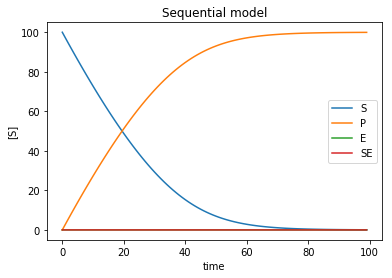

In [5]:
#Simulate Sequential model
init=(So,E,SE,P)# pack initial conditions into tuple
args=(k1,k1r,k2) # pack arguments into tuple

z = odeint(model_full,init,t,args) # solve model_full by integration of ordinary differential equations (ODE)
#print(z[:,0])   

simdata['S']=z[:,0]
simdata['E']=z[:,1]
simdata['SE']=z[:,2]
simdata['P']=z[:,3]
noise_level=.03 # we may add some random noise to the data
noise = np.random.normal(0, 1, simdata['S'].shape)*simdata['S'].max()*noise_level
simdata['ZZZ'] = simdata['S'] + noise
# plot results
plt.plot(simdata['time'],simdata['S'])
plt.plot(simdata['time'],simdata['P'])
plt.plot(simdata['time'],simdata['E'])
plt.plot(simdata['time'],simdata['SE'])
#plt.scatter(simdata['time'],simdata['ZZZ'])
plt.title('Sequential model')
plt.xlabel('time')
plt.ylabel('[S]')
plt.legend()
plt.show()


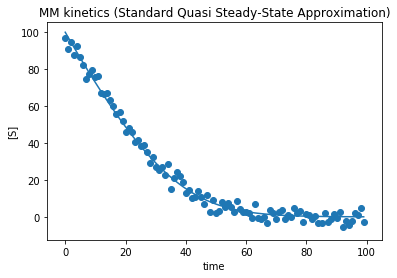

In [6]:
#Simulate MM kinetics (Standard Quasi Steady-State Approximation) using differential form

args=(KM,Vm)
z = odeint(modelMM,So,t,args)
simdata['MM']=z
# plot results
plt.plot(simdata['time'],simdata['MM'])
plt.scatter(simdata['time'],simdata['ZZZ'])
plt.title('MM kinetics (Standard Quasi Steady-State Approximation)')
plt.xlabel('time')
plt.ylabel('[S]')
plt.show()


In [7]:
#Simulate MM kinetics (Total Quasi Steady-State Approximation)
args=(KM,k2,E)
z = odeint(modelTMM,So,t,args)
simdata['TMM']=z
#simdata.to_csv('../data/simulatedMM.csv',index=False) #save the table in a file
# plot results
plt.plot(simdata['time'],simdata['TMM'])
plt.scatter(simdata['time'],simdata['ZZZ'])
plt.title('MM kinetics (Total Quasi Steady-State Approximation)')
plt.xlabel('time')
plt.ylabel('[S]')
plt.show()


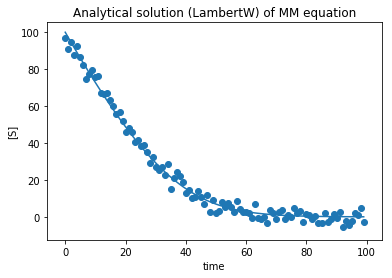

In [8]:
#Simulate kinetics with analytical solution (LambertW) of MM equation
simdata['W']=modelW(simdata.time,KM,Vm,So) # add a column with fitted values to our DataFrame 
#simdata.to_csv('../data/simulatedMM.csv',index=False) #save the table into a file
plt.plot(simdata['time'],simdata['W'])
plt.scatter(simdata['time'],simdata['ZZZ'])
plt.title('Analytical solution (LambertW) of MM equation')
plt.xlabel('time')
plt.ylabel('[S]')
plt.show()



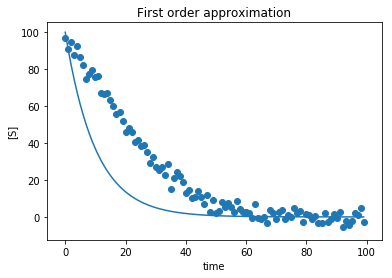

In [9]:
#Simulate kinetics with First order approximation
k=Vm/KM
#simdata=pandas.DataFrame()
simdata['EXP']=modelEXP(simdata.time,So,k) # add a column with fitted values to our DataFrame 
#simdata.to_csv('../data/simulatedMM.csv',index=False) #save the table into a file
plt.plot(simdata['time'],simdata['EXP'])
plt.scatter(simdata['time'],simdata['ZZZ'])
plt.title('First order approximation')
plt.xlabel('time')
plt.ylabel('[S]')
plt.show()

### Simulations are complete. We will save the DataFrame into comma separated value (csv) file. Then read it into another DataFrame

In [10]:
simdata.to_csv('../data/simulatedMM.csv',index=False) #save the table into a file
simdata=pandas.read_csv('../data/simulatedMM.csv')  # Input experimental data
#data.drop(['ZZZ','EXP'], axis=1, inplace=True)
#print(data)

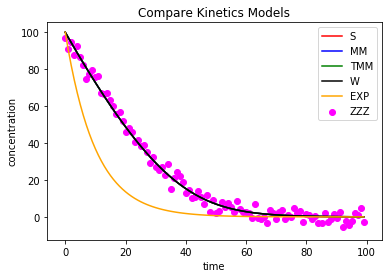

In [11]:
#%matplotlib auto
#plt.ioff()
fig = plt.figure() # create pyplot object
plt.plot(simdata.time, simdata.S, c='red') #add a scatter plot with original data
plt.plot(simdata.time, simdata.MM, c='blue') #add a scatter plot with original data
plt.plot(simdata.time, simdata.TMM, c='green') #add a scatter plot with original data
plt.plot(simdata.time, simdata.W, c='black') #add a scatter plot with original data
plt.plot(simdata.time, simdata.EXP, c='orange') #add a scatter plot with original data
plt.scatter(simdata.time, simdata.ZZZ, c='magenta') #add a scatter plot with original data

plt.legend()
plt.title('Compare Kinetics Models')
plt.xlabel('time')
plt.ylabel('concentration')
plt.show()

### Let's simulate data at several initial concentration of [S]o 

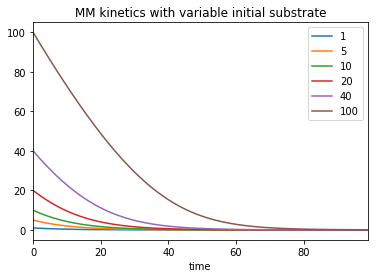

In [12]:
data=pandas.DataFrame()
data['time']=t
for conc in [1,5,10,20,40,100]:
    So=conc
    init=(So,E,SE,P)# pack initial conditions into tuple
    args=(k1,k1r,k2) # pack arguments into tuple
    z = odeint(model_full,init,t,args) # solve model_full by integration of ordinary differential equations (ODE)
    noise_level=.03 # we may add some random noise to the data
    noise = np.random.normal(0, 1, z.shape)*z.max()*noise_level
    #z=z+noise
    data[str(So)]=z[:,0]
data.plot(x='time',y=['1','5','10','20','40','100'],kind='line',
          title='MM kinetics with variable initial substrate') 
# Lazy way to plot a DataFrame 
plt.show()


In [13]:
data.to_csv('../data/simulatedMM_variable_S.csv',index=False) #save the table into a file
